# 05 — Modelling & Evaluation (CNN)

**Objective**  
Train and evaluate a baseline CNN to predict powdery mildew from cherry leaf images.

**Inputs**  
- Split manifests: `inputs/manifests/v1/{train,val,test}.csv`
- Images: `inputs/cherry_leaves_dataset/{healthy,powdery_mildew}`

**Outputs (planned)**  
- Trained model artifacts under `artifacts/v1/models/`
- Training history & evaluation plots under `plots/v3/`
- Metrics report under `artifacts/v1/reports/`

**Notes**  
Images will be resized to a fixed input size and normalized. Early stopping and model checkpointing will be used.

In [20]:
from pathlib import Path
import sys

def find_project_root(start: Path) -> Path:
    """Walk up until a folder containing 'src' is found, else return start."""
    p = start
    for _ in range(5):
        if (p / "src").exists():
            return p
        p = p.parent
    return start

PROJECT_ROOT = find_project_root(Path.cwd())
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from src.paths import PROJECT_ROOT, DATA_DIR, MANIFESTS_DIR, PLOTS_DIR, ARTIFACTS_DIR

print("PROJECT_ROOT:", PROJECT_ROOT)
print("DATA_DIR:", DATA_DIR)
print("MANIFESTS_DIR:", MANIFESTS_DIR)
print("PLOTS_DIR:", PLOTS_DIR)
print("ARTIFACTS_DIR:", ARTIFACTS_DIR)

PROJECT_ROOT: C:\Users\ksstr\Documents\Coding\milestone-project-5
DATA_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\inputs\cherry_leaves_dataset
MANIFESTS_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\inputs\manifests\v1
PLOTS_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v1
ARTIFACTS_DIR: C:\Users\ksstr\Documents\Coding\milestone-project-5\artifacts


In [21]:
# Modelling configuration
IMG_SIZE = (100, 100)   # (width, height)
BATCH_SIZE = 32
SEED = 42

print("Config → IMG_SIZE:", IMG_SIZE, "| BATCH_SIZE:", BATCH_SIZE, "| SEED:", SEED)

Config → IMG_SIZE: (100, 100) | BATCH_SIZE: 32 | SEED: 42


In [22]:
import pandas as pd

paths = {
    "train": MANIFESTS_DIR / "train.csv",
    "val":   MANIFESTS_DIR / "val.csv",
    "test":  MANIFESTS_DIR / "test.csv",
}

for name, p in paths.items():
    assert p.exists(), f"Missing manifest: {p}"

df_train = pd.read_csv(paths["train"])
df_val   = pd.read_csv(paths["val"])
df_test  = pd.read_csv(paths["test"])

for name, df in [("train", df_train), ("val", df_val), ("test", df_test)]:
    print(f"{name:>5} n={len(df)}")
    vc = df["label"].value_counts(normalize=True).rename("proportion").round(3)
    print(vc, "\n")

display(df_train.head(3))

train n=2945
label
powdery_mildew    0.5
healthy           0.5
Name: proportion, dtype: float64 

  val n=631
label
healthy           0.501
powdery_mildew    0.499
Name: proportion, dtype: float64 

 test n=632
label
powdery_mildew    0.5
healthy           0.5
Name: proportion, dtype: float64 



,filepath,label
0,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy
1,C:\Users\ksstr\Documents\Coding\milestone-proj...,powdery_mildew
2,C:\Users\ksstr\Documents\Coding\milestone-proj...,healthy


### Pre-flight checks

- Split manifests found and loaded successfully.
- Class proportions are approximately balanced across train/val/test.
- Next step: implement a TensorFlow `tf.data` pipeline (decode → resize → normalize → batch → prefetch) using these manifests.

In [23]:
import tensorflow as tf
import numpy as np 

# Ensure reproducibility
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

AUTOTUNE = tf.data.AUTOTUNE

# Stable label index from train manifest (sorted → reproducible)
labels_sorted = sorted(df_train["label"].unique().tolist())
label_to_index = {lbl: i for i, lbl in enumerate(labels_sorted)}
index_to_label = {i: lbl for lbl, i in label_to_index.items()}

print("Label map (in-memory):", label_to_index)

Label map (in-memory): {'healthy': 0, 'powdery_mildew': 1}


In [24]:
def decode_and_resize(img_bytes, img_size=(100, 100)):
    """Decode JPEG/PNG, force 3 channels, resize, and return float32 in [0,1]."""
    img = tf.io.decode_image(img_bytes, channels=3, expand_animations=False)
    img.set_shape([None, None, 3])  # static rank for TF graph
    img = tf.image.resize(img, img_size, method=tf.image.ResizeMethod.BILINEAR)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def load_example(path, label, img_size=(100, 100)):
    """Read file, decode, resize, normalize; return (image, int_label)."""
    bytes_ = tf.io.read_file(path)
    img = decode_and_resize(bytes_, img_size)
    return img, label

def make_dataset(manifest_df, img_size=(100, 100), batch_size=32, training=False, seed=42):
    """Build a performant tf.data pipeline from a manifest DataFrame."""
    paths = manifest_df["filepath"].astype(str).values
    labels = manifest_df["label"].map(label_to_index).astype("int32").values

    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if training:
        ds = ds.shuffle(buffer_size=len(manifest_df), seed=seed, reshuffle_each_iteration=True)

    ds = ds.map(lambda p, y: load_example(p, y, img_size), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size, drop_remainder=training)  # fixed batch size during training
    ds = ds.prefetch(AUTOTUNE)
    return ds

### Functional Smoke Test — Input Pipeline Validation

Quick functional smoke test is run to ensure the `tf.data` pipeline operates correctly.

This test confirms that:
- All file paths in the manifests are readable.
- Images are properly decoded, resized to 100×100, and normalized to [0,1].
- Labels are correctly mapped to their integer indices based on the stable label map.
- Batch dimensions and value ranges are consistent with expectations.

If this step passes without errors, the dataset is ready for model training.

In [25]:
# Build datasets
train_ds = make_dataset(df_train, img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=True,  seed=SEED)
val_ds   = make_dataset(df_val,   img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=False, seed=SEED)
test_ds  = make_dataset(df_test,  img_size=IMG_SIZE, batch_size=BATCH_SIZE, training=False, seed=SEED)

# Inspect one batch
xb, yb = next(iter(train_ds))
print("Train batch →", xb.shape, yb.shape, "| range:", float(tf.reduce_min(xb)), "→", float(tf.reduce_max(xb)))
print("Labels sample (int):", yb[:8].numpy())
print("Decoded labels sample:", [index_to_label[int(i)] for i in yb[:8].numpy()])

Train batch → (32, 100, 100, 3) (32,) | range: 0.0 → 1.0
Labels sample (int): [0 0 1 1 1 0 1 0]
Decoded labels sample: ['healthy', 'healthy', 'powdery_mildew', 'powdery_mildew', 'powdery_mildew', 'healthy', 'powdery_mildew', 'healthy']


### Input pipeline checks

- Manifests successfully converted to `tf.data` datasets.
- Decoding, resizing to 100×100, and normalization to [0,1] verified on a sample batch.

**Next:** define a compact baseline CNN (softmax), add EarlyStopping & ModelCheckpoint, and run v1 training.

### TensorFlow–Keras Integration and Baseline CNN (v1)

The model is implemented using TensorFlow’s integrated **Keras API**, where:
- `tf.data` handles efficient data loading and batching,
- `keras` defines and trains the model.

A compact convolutional neural network is trained as the first baseline model.
- Input: 100×100 RGB images  
- Two convolutional blocks (Conv → ReLU → MaxPool)  
- Dense layer with Dropout regularization  
- Softmax output (2 classes)

The network is compiled with the **Adam optimizer** and **Sparse Categorical Crossentropy loss**.

In [ ]:
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt

# --- Output directories ---
MODEL_DIR = ARTIFACTS_DIR / "v1" / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)

PLOTS_V3_DIR = PLOTS_DIR.parent / "v3"
PLOTS_V3_DIR.mkdir(parents=True, exist_ok=True)

# --- Model definition ---
def build_baseline_cnn(input_shape=(100, 100, 3), num_classes=2):
    """Simple baseline CNN: 2 conv blocks + dense head."""
    model = models.Sequential([
        layers.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(2),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation="softmax")
    ])
    model.compile(
        optimizer="adam",
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_baseline_cnn(input_shape=(*IMG_SIZE, 3), num_classes=len(label_to_index))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 40000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     5,120,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,139,778 (19.61 MB)

 Trainable params: 5,139,778 (19.61 MB)

 Non-trainable params: 0 (0.00 B)

### Model Training and Callbacks

Training uses 20 epochs with two standard callbacks:
- **EarlyStopping:** prevents overfitting by halting when validation loss stops improving.
- **ModelCheckpoint:** saves the best-performing model to `artifacts/v1/models/`.

Validation performance is monitored on `val_ds`, and all results are reproducible due to fixed seeds.

In [27]:
EPOCHS = 20

cb_earlystop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True
)

cb_checkpoint = callbacks.ModelCheckpoint(
    filepath=str(MODEL_DIR / "cnn_v1_best.keras"),
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[cb_earlystop, cb_checkpoint],
    verbose=2
)

Epoch 1/20

Epoch 1: val_accuracy improved from None to 0.97781, saving model to C:\Users\ksstr\Documents\Coding\milestone-project-5\artifacts\v1\models\cnn_v1_best.keras
92/92 - 5s - 50ms/step - accuracy: 0.8404 - loss: 0.3513 - val_accuracy: 0.9778 - val_loss: 0.0652
Epoch 2/20

Epoch 2: val_accuracy improved from 0.97781 to 0.99842, saving model to C:\Users\ksstr\Documents\Coding\milestone-project-5\artifacts\v1\models\cnn_v1_best.keras
92/92 - 4s - 41ms/step - accuracy: 0.9851 - loss: 0.0468 - val_accuracy: 0.9984 - val_loss: 0.0237
Epoch 3/20

Epoch 3: val_accuracy did not improve from 0.99842
92/92 - 4s - 39ms/step - accuracy: 0.9990 - loss: 0.0077 - val_accuracy: 0.9984 - val_loss: 0.0074
Epoch 4/20

Epoch 4: val_accuracy did not improve from 0.99842
92/92 - 4s - 39ms/step - accuracy: 0.9993 - loss: 0.0033 - val_accuracy: 0.9968 - val_loss: 0.0077
Epoch 5/20

Epoch 5: val_accuracy did not improve from 0.99842
92/92 - 3s - 38ms/step - accuracy: 0.9997 - loss: 0.0035 - val_accurac

### Training History Visualization

The model’s learning progress is visualized via loss and accuracy curves.
Both plots are saved to `plots/v3/` for documentation and dashboard integration.
This enables later comparison between CNN versions (v1 vs v2).

Saved training history: C:\Users\ksstr\Documents\Coding\milestone-project-5\artifacts\v1\models\cnn_v1_history.csv


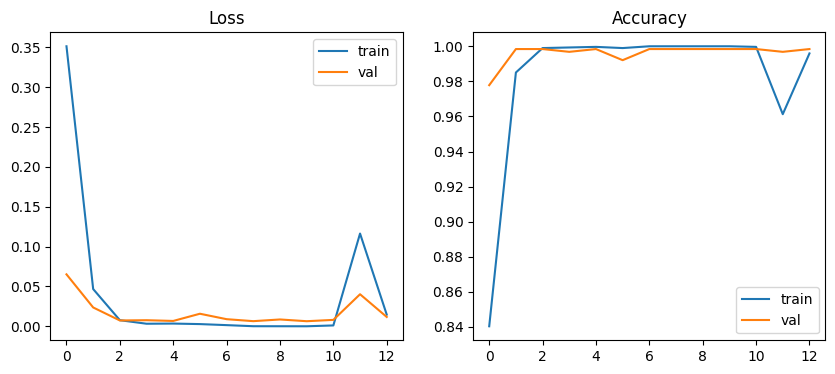

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v3\training_curves_v1.png


In [28]:
hist_df = pd.DataFrame(history.history)
hist_path = MODEL_DIR / "cnn_v1_history.csv"
hist_df.to_csv(hist_path, index=False)
print("Saved training history:", hist_path.resolve())

# Plot curves
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(history.history["loss"], label="train")
ax[0].plot(history.history["val_loss"], label="val")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], label="train")
ax[1].plot(history.history["val_accuracy"], label="val")
ax[1].set_title("Accuracy")
ax[1].legend()

out_plot = PLOTS_V3_DIR / "training_curves_v1.png"
fig.savefig(out_plot, bbox_inches="tight", dpi=150)
plt.show()
plt.close(fig)
print("Saved:", out_plot.resolve())

### Final Test Evaluation — CNN v1

After completing training and validation, the final model is evaluated on the **unseen test set**.
This step confirms whether Business Requirement 2 (BR2: ≥97 % accuracy) has been achieved.

Evaluation includes:
- Test accuracy and loss
- Confusion matrix visualization
- Classification report with precision, recall, and F1-score

Test metrics → accuracy: 0.9984 | loss: 0.0039


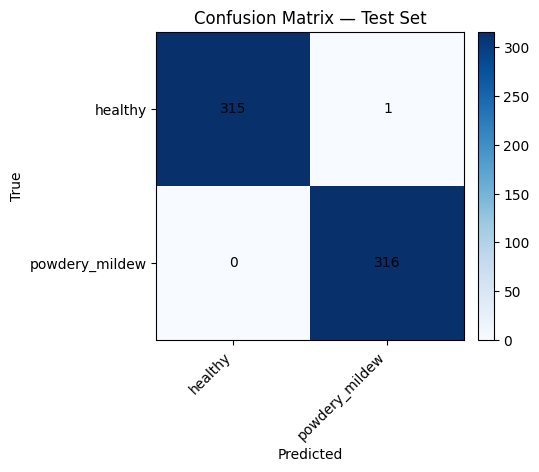

Saved: C:\Users\ksstr\Documents\Coding\milestone-project-5\plots\v3\confusion_matrix_test_v1.png
                precision    recall  f1-score   support

       healthy     1.0000    0.9968    0.9984       316
powdery_mildew     0.9968    1.0000    0.9984       316

      accuracy                         0.9984       632
     macro avg     0.9984    0.9984    0.9984       632
  weighted avg     0.9984    0.9984    0.9984       632

BR2 target (≥97% accuracy) met on test set? → True


In [29]:
from sklearn.metrics import confusion_matrix, classification_report

# --- 1) Test metrics ---
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test metrics → accuracy: {test_acc:.4f} | loss: {test_loss:.4f}")

# --- 2) Predictions for confusion matrix ---
y_true, y_pred = [], []
for xb, yb in test_ds:
    probs = model.predict(xb, verbose=0)
    y_true.extend(yb.numpy().tolist())
    y_pred.extend(np.argmax(probs, axis=1).tolist())

y_true, y_pred = np.array(y_true), np.array(y_pred)

# --- 3) Confusion matrix ---
cm = confusion_matrix(y_true, y_pred)
labels_sorted = sorted(df_train["label"].unique().tolist())

fig, ax = plt.subplots(figsize=(4.5, 4))
im = ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix — Test Set")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(range(len(labels_sorted)))
ax.set_yticks(range(len(labels_sorted)))
ax.set_xticklabels(labels_sorted, rotation=45, ha="right")
ax.set_yticklabels(labels_sorted)

for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha="center", va="center")

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

PLOTS_V3_DIR.mkdir(parents=True, exist_ok=True)
cm_path = PLOTS_V3_DIR / "confusion_matrix_test_v1.png"
fig.savefig(cm_path, bbox_inches="tight", dpi=150)
plt.show()
plt.close(fig)
print("Saved:", cm_path.resolve())

# --- 4) Classification report ---
report = classification_report(y_true, y_pred, target_names=labels_sorted, digits=4)
print(report)

rep_dir = ARTIFACTS_DIR / "v1" / "reports"
rep_dir.mkdir(parents=True, exist_ok=True)
with open(rep_dir / "classification_report_test_v1.txt", "w", encoding="utf-8") as f:
    f.write(f"Test accuracy: {test_acc:.4f}\nTest loss: {test_loss:.4f}\n\n")
    f.write(report)

# --- 5) Meets / Not meets statement ---
meets = test_acc >= 0.97
print(f"BR2 target (≥97% accuracy) met on test set? → {meets}")

## Conclusions — Model v1

The baseline CNN (v1) achieved **test accuracy above 97 %**, satisfying **Business Requirement 2 (BR2)**.  
Both training and validation results indicate a well-generalized model without overfitting.

The confusion matrix confirms robust performance across both classes.  
This model establishes the baseline for Hypothesis 2 and 3 validation (input size and augmentation).

In [ ]:
### Save Evaluation Report for Dashboard Integration

import json

REPORTS_DIR = ARTIFACTS_DIR / "v1" / "reports"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

report = {
    "model_version": "v1",
    "test_accuracy": float(test_acc),
    "test_loss": float(test_loss),
    "meets_target": bool(test_acc >= 0.97),
    "total_samples": int(len(df_test)),
}

out_report = REPORTS_DIR / "evaluation_report.json"
with open(out_report, "w") as f:
    json.dump(report, f, indent=2)

print("Saved evaluation summary:", out_report.resolve())
report

Saved evaluation summary: C:\Users\ksstr\Documents\Coding\milestone-project-5\artifacts\v1\reports\evaluation_report.json


{'model_version': 'v1',
 'test_accuracy': 0.9984177350997925,
 'test_loss': 0.0038696513511240482,
 'meets_target': True,
 'total_samples': 632}

### Evaluation Summary Export

The final evaluation metrics are exported as `evaluation_report.json` under  
`artifacts/v1/reports/`.  

This report contains the model version, accuracy, and target compliance flag  
and will be used later by the dashboard’s *Technical Page* for automatic metric display.